In [1]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [2]:
#Set figure resolution to 300dpi
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
#Set the max rows displayed in pandas
pd.set_option('display.max_rows', 10)

In [4]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(20, 20))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

In [5]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [6]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [7]:
#LOAD DATA
df = pd.read_csv('./CSVExport.csv', index_col=0) #This is the txt file output from PD imported as dataframe "df"


In [8]:
df

,OBJECTID,AMA SITE CODE,Location,STATE,NATTS Site?,Latitude,Longitude,Type,Setting,NATA HAP Name,...,Toluene (µg/m3),Toxaphene (Chlorinated Camphene) (µg/m3),Trichloroethylene (µg/m3),Triethylamine (µg/m3),Trifluralin (µg/m3),Vinyl Acetate (µg/m3),Vinyl Bromide (µg/m3),Vinyl Chloride (µg/m3),Vinylidene Chloride (µg/m3),Xylenes (Mixed Isomers) (µg/m3)
Row Number,,,,,,,,,,,,,,,,,,,,,
1,58,20200018,NaN,AK,0,61.205860,-149.824600,SUBURBAN,NaN,NAPHTHALENE,...,4.203952,NaN,0.009107,0.001888,NaN,0.000064,NaN,0.000116,0.000003,2.273865
2,184,10735503,NaN,AL,0,33.568401,-86.802902,URBAN AND CENTER CITY,NaN,NAPHTHALENE,...,2.093985,NaN,0.031461,0.001022,NaN,0.000046,NaN,0.000492,0.000269,1.157399
3,617,40139997,"Phoenix, AZ",AZ,1,33.503731,-112.095809,URBAN AND CENTER CITY,Urban,NAPHTHALENE,...,3.353296,NaN,0.001794,0.002885,NaN,0.000115,NaN,0.000038,0.000003,1.555841
4,2191,60371103,"Los Angeles, CA",CA,1,34.066590,-118.226880,URBAN AND CENTER CITY,Urban,NAPHTHALENE,...,5.209938,NaN,0.091247,0.002611,NaN,0.000584,NaN,0.000323,0.000018,2.675677
5,2836,60658001,"Rubidoux, CA",CA,1,33.999580,-117.416010,SUBURBAN,Urban,NAPHTHALENE,...,2.660852,NaN,0.043902,0.001325,NaN,0.000136,NaN,0.000292,0.000002,1.408800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,28435,530330080,"Seattle, WA",WA,1,47.568333,-122.308056,URBAN AND CENTER CITY,Urban,NAPHTHALENE,...,12.869431,NaN,0.047392,0.005698,NaN,0.000061,NaN,0.000087,0.000048,5.725036
68,28553,530530029,NaN,WA,0,47.186401,-122.451698,SUBURBAN,NaN,NAPHTHALENE,...,6.885934,NaN,0.009594,0.002090,NaN,0.000066,NaN,0.000386,0.000011,2.161355
69,28618,530530031,NaN,WA,0,47.265598,-122.385803,SUBURBAN,NaN,NAPHTHALENE,...,4.277377,NaN,0.007888,0.002064,NaN,0.000062,NaN,0.000421,0.000071,1.732706


# 

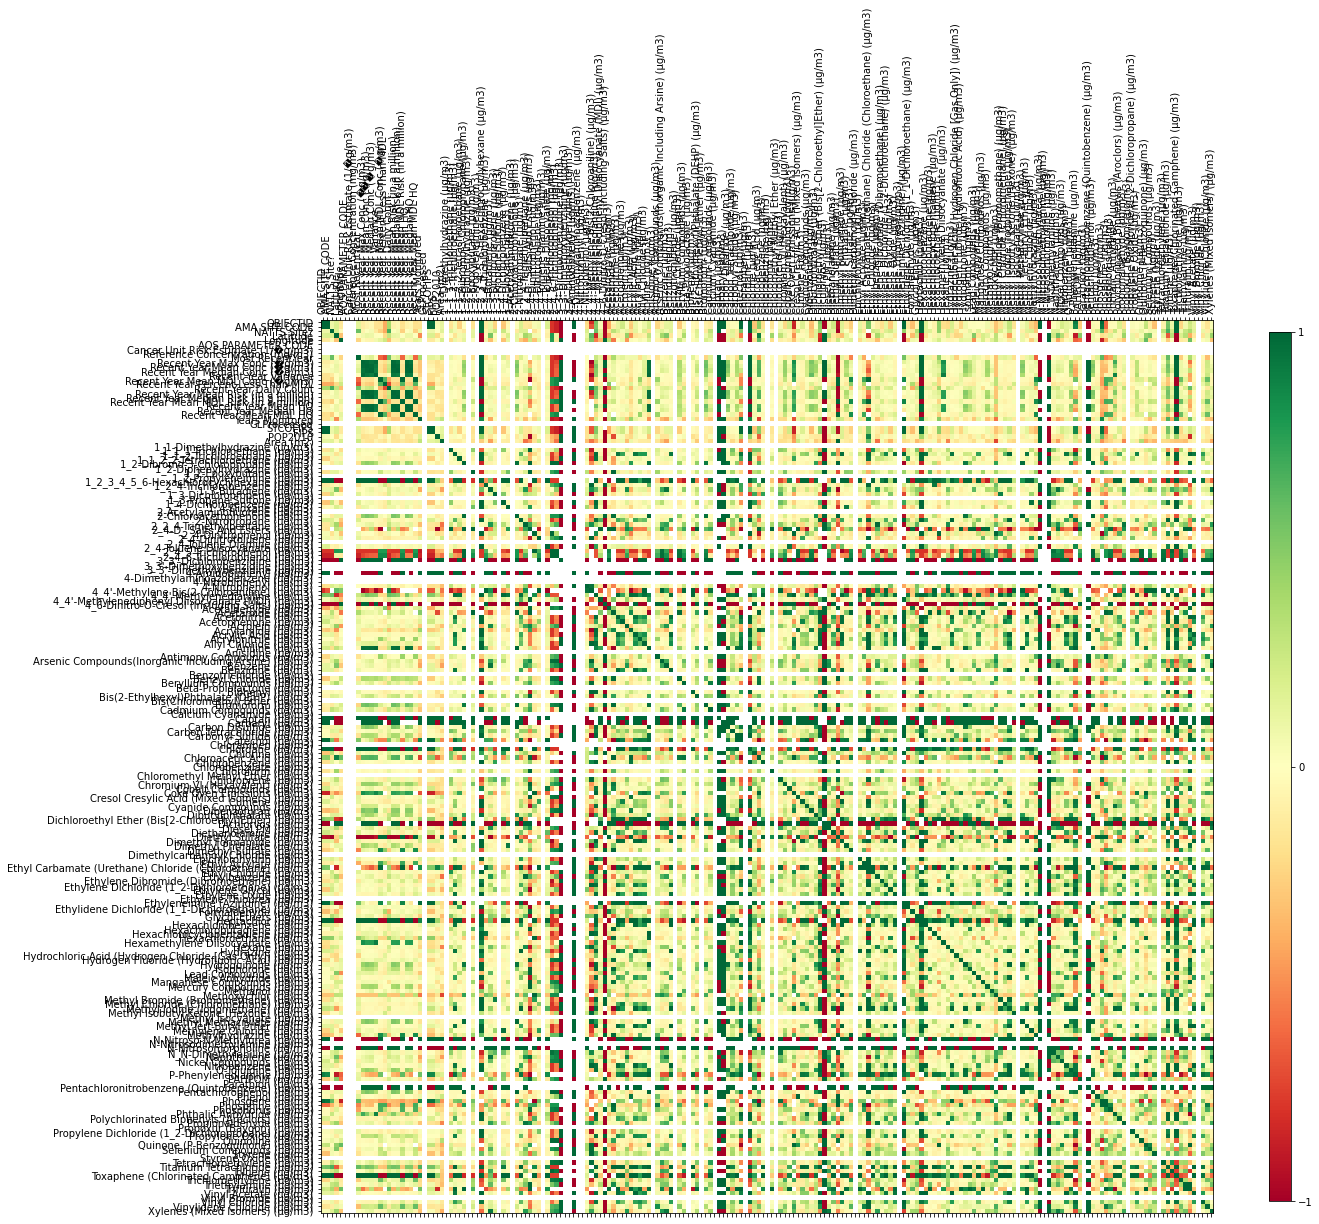

In [9]:
#A kind of worthless visualization
plot_corr(df)

In [10]:
dft = df.transpose()
dft.head()

Row Number,1,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
OBJECTID,58,184,617,2191,2836,3629,4411,4624,5393,5693,...,26940,27060,27370,27862,28358,28435,28553,28618,28939,29009
AMA SITE CODE,20200018,10735503,40139997,60371103,60658001,60850005,80770018,110010043,120573002,121030026,...,484790016,490110004,510870014,500070007,530330057,530330080,530530029,530530031,550270001,550270007
Location,NaN,NaN,"Phoenix, AZ","Los Angeles, CA","Rubidoux, CA","San Jose, CA","Grand Junction, CO-18","Washington, DC","Tampa, FL","Pinellas County, FL",...,NaN,"Bountiful, UT","Richmond, VA","Underhill, VT",NaN,"Seattle, WA",NaN,NaN,"Horicon, WI","Mayville, WI"
STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
NATTS Site?,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,0,1,1


In [11]:
#drop missing values 
dfd = dft.dropna()
dfd

Row Number,1,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
OBJECTID,58,184,617,2191,2836,3629,4411,4624,5393,5693,...,26940,27060,27370,27862,28358,28435,28553,28618,28939,29009
AMA SITE CODE,20200018,10735503,40139997,60371103,60658001,60850005,80770018,110010043,120573002,121030026,...,484790016,490110004,510870014,500070007,530330057,530330080,530530029,530530031,550270001,550270007
STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
NATTS Site?,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,0,1,1
Latitude,61.20586,33.568401,33.503731,34.06659,33.99958,37.348497,39.06425,38.921847,27.96565,27.850041,...,27.511267,40.902967,37.55655,44.52839,47.55975,47.568333,47.186401,47.265598,43.466111,43.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),0.009107,0.031461,0.001794,0.091247,0.043902,0.084937,0.000413,0.007729,0.000532,0.004724,...,0.0042,0.003379,0.00888,0.001364,0.037683,0.047392,0.009594,0.007888,0.005596,0.004473
Triethylamine (µg/m3),0.001888,0.001022,0.002885,0.002611,0.001325,0.001901,0.000436,0.002597,0.00062,0.002122,...,0.000438,0.002608,0.001828,0.000061,0.005738,0.005698,0.00209,0.002064,0.000289,0.000224
Vinyl Acetate (µg/m3),0.000064,0.000046,0.000115,0.000584,0.000136,0.004423,0.000035,0.000183,0.000041,0.000064,...,0.000039,0.00008,0.000073,0.000065,0.000076,0.000061,0.000066,0.000062,0.000038,0.000057
Vinyl Chloride (µg/m3),0.000116,0.000492,0.000038,0.000323,0.000292,0.002786,0.000543,0.000354,0.000205,0.005374,...,0.000042,0.000209,0.000279,0.000183,0.000085,0.000087,0.000386,0.000421,0.000147,0.000191


In [12]:
#convert missing values to 0
df0 = dft.fillna(0)
df0.head(10)

Row Number,1,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
OBJECTID,58,184,617,2191,2836,3629,4411,4624,5393,5693,...,26940,27060,27370,27862,28358,28435,28553,28618,28939,29009
AMA SITE CODE,20200018,10735503,40139997,60371103,60658001,60850005,80770018,110010043,120573002,121030026,...,484790016,490110004,510870014,500070007,530330057,530330080,530530029,530530031,550270001,550270007
Location,0,0,"Phoenix, AZ","Los Angeles, CA","Rubidoux, CA","San Jose, CA","Grand Junction, CO-18","Washington, DC","Tampa, FL","Pinellas County, FL",...,0,"Bountiful, UT","Richmond, VA","Underhill, VT",0,"Seattle, WA",0,0,"Horicon, WI","Mayville, WI"
STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
NATTS Site?,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,0,1,1
Latitude,61.20586,33.568401,33.503731,34.06659,33.99958,37.348497,39.06425,38.921847,27.96565,27.850041,...,27.511267,40.902967,37.55655,44.52839,47.55975,47.568333,47.186401,47.265598,43.466111,43.435
Longitude,-149.8246,-86.802902,-112.095809,-118.22688,-117.41601,-121.894898,-108.561605,-77.013178,-82.2304,-82.71459,...,-99.520287,-111.884467,-77.400411,-72.86884,-122.338265,-122.308056,-122.451698,-122.385803,-88.621111,-88.527778
Type,SUBURBAN,URBAN AND CENTER CITY,URBAN AND CENTER CITY,URBAN AND CENTER CITY,SUBURBAN,URBAN AND CENTER CITY,URBAN AND CENTER CITY,URBAN AND CENTER CITY,RURAL,SUBURBAN,...,SUBURBAN,SUBURBAN,SUBURBAN,RURAL,SUBURBAN,URBAN AND CENTER CITY,SUBURBAN,SUBURBAN,RURAL,RURAL
Setting,0,0,Urban,Urban,Urban,Urban,Urban,Urban,Urban,Urban,...,0,Urban,Urban,Rural,0,Urban,0,0,Rural,Rural
NATA HAP Name,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,...,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE


In [13]:
dfd.columns = dfd.iloc[2]
dfd


STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,58,184,617,2191,2836,3629,4411,4624,5393,5693,...,26940,27060,27370,27862,28358,28435,28553,28618,28939,29009
AMA SITE CODE,20200018,10735503,40139997,60371103,60658001,60850005,80770018,110010043,120573002,121030026,...,484790016,490110004,510870014,500070007,530330057,530330080,530530029,530530031,550270001,550270007
STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
NATTS Site?,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,0,1,1
Latitude,61.20586,33.568401,33.503731,34.06659,33.99958,37.348497,39.06425,38.921847,27.96565,27.850041,...,27.511267,40.902967,37.55655,44.52839,47.55975,47.568333,47.186401,47.265598,43.466111,43.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),0.009107,0.031461,0.001794,0.091247,0.043902,0.084937,0.000413,0.007729,0.000532,0.004724,...,0.0042,0.003379,0.00888,0.001364,0.037683,0.047392,0.009594,0.007888,0.005596,0.004473
Triethylamine (µg/m3),0.001888,0.001022,0.002885,0.002611,0.001325,0.001901,0.000436,0.002597,0.00062,0.002122,...,0.000438,0.002608,0.001828,0.000061,0.005738,0.005698,0.00209,0.002064,0.000289,0.000224
Vinyl Acetate (µg/m3),0.000064,0.000046,0.000115,0.000584,0.000136,0.004423,0.000035,0.000183,0.000041,0.000064,...,0.000039,0.00008,0.000073,0.000065,0.000076,0.000061,0.000066,0.000062,0.000038,0.000057
Vinyl Chloride (µg/m3),0.000116,0.000492,0.000038,0.000323,0.000292,0.002786,0.000543,0.000354,0.000205,0.005374,...,0.000042,0.000209,0.000279,0.000183,0.000085,0.000087,0.000386,0.000421,0.000147,0.000191


In [14]:
dfdt = dfd.transpose()
dfdt

,OBJECTID,AMA SITE CODE,STATE,NATTS Site?,Latitude,Longitude,Type,NATA HAP Name,AQS PARAMETER CODE,AQS PARAMETER NAME,...,Propylene Dichloride (1_2-Dichloropropane) (µg/m3),Selenium Compounds (µg/m3),Styrene (µg/m3),Tetrachloroethylene (µg/m3),Toluene (µg/m3),Trichloroethylene (µg/m3),Triethylamine (µg/m3),Vinyl Acetate (µg/m3),Vinyl Chloride (µg/m3),Xylenes (Mixed Isomers) (µg/m3)
STATE,,,,,,,,,,,,,,,,,,,,,
AK,58,20200018,AK,0,61.20586,-149.8246,SUBURBAN,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000286,0.001009,0.038551,0.031786,4.203952,0.009107,0.001888,0.000064,0.000116,2.273865
AL,184,10735503,AL,0,33.568401,-86.802902,URBAN AND CENTER CITY,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000068,0.000286,0.023536,0.049028,2.093985,0.031461,0.001022,0.000046,0.000492,1.157399
AZ,617,40139997,AZ,1,33.503731,-112.095809,URBAN AND CENTER CITY,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000005,0.000204,0.034803,0.143608,3.353296,0.001794,0.002885,0.000115,0.000038,1.555841
CA,2191,60371103,CA,1,34.06659,-118.22688,URBAN AND CENTER CITY,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000017,0.00029,0.04077,0.88772,5.209938,0.091247,0.002611,0.000584,0.000323,2.675677
CA,2836,60658001,CA,1,33.99958,-117.41601,SUBURBAN,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000013,0.000298,0.030017,0.392185,2.660852,0.043902,0.001325,0.000136,0.000292,1.4088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WA,28435,530330080,WA,1,47.568333,-122.308056,URBAN AND CENTER CITY,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.00002,0.000801,0.03135,0.229332,12.869431,0.047392,0.005698,0.000061,0.000087,5.725036
WA,28553,530530029,WA,0,47.186401,-122.451698,SUBURBAN,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.00005,0.000208,0.037277,0.085374,6.885934,0.009594,0.00209,0.000066,0.000386,2.161355
WA,28618,530530031,WA,0,47.265598,-122.385803,SUBURBAN,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000084,0.000212,0.029734,0.062312,4.277377,0.007888,0.002064,0.000062,0.000421,1.732706


In [15]:
#remove columns that are not float (remove non-numeric values)
cols_to_remove = []

for col in dfdt.columns:
    try:
        _ = dfdt[col].astype(float)
    except ValueError:
        print('Couldn\'t covert %s to float' % col)
        cols_to_remove.append(col)
        pass

# keep only the columns in df that do not contain string
dfdtn = dfdt[[col for col in dfdt.columns if col not in cols_to_remove]]

Couldn't covert STATE to float
Couldn't covert Type to float
Couldn't covert NATA HAP Name to float
Couldn't covert AQS PARAMETER NAME to float
Couldn't covert Pollutant Code Description to float
Couldn't covert Duration Description to float
Couldn't covert Trends Plot to float
Couldn't covert intersected to float
Couldn't covert State to float
Couldn't covert County to float


In [16]:
dfdtn

,OBJECTID,AMA SITE CODE,NATTS Site?,Latitude,Longitude,AQS PARAMETER CODE,Cancer Unit Risk Estimate (1/�g/m3),Reference Concentration (mg/m3),Most RecentYear,Recent Year Max Conc (�g/m3),...,Propylene Dichloride (1_2-Dichloropropane) (µg/m3),Selenium Compounds (µg/m3),Styrene (µg/m3),Tetrachloroethylene (µg/m3),Toluene (µg/m3),Trichloroethylene (µg/m3),Triethylamine (µg/m3),Vinyl Acetate (µg/m3),Vinyl Chloride (µg/m3),Xylenes (Mixed Isomers) (µg/m3)
STATE,,,,,,,,,,,,,,,,,,,,,
AK,58,20200018,0,61.20586,-149.8246,17141,0.000034,0.003,2013,0.31017,...,0.000286,0.001009,0.038551,0.031786,4.203952,0.009107,0.001888,0.000064,0.000116,2.273865
AL,184,10735503,0,33.568401,-86.802902,17141,0.000034,0.003,2012,5.73417,...,0.000068,0.000286,0.023536,0.049028,2.093985,0.031461,0.001022,0.000046,0.000492,1.157399
AZ,617,40139997,1,33.503731,-112.095809,17141,0.000034,0.003,2013,0.28489,...,0.000005,0.000204,0.034803,0.143608,3.353296,0.001794,0.002885,0.000115,0.000038,1.555841
CA,2191,60371103,1,34.06659,-118.22688,17141,0.000034,0.003,2013,0.34986,...,0.000017,0.00029,0.04077,0.88772,5.209938,0.091247,0.002611,0.000584,0.000323,2.675677
CA,2836,60658001,1,33.99958,-117.41601,17141,0.000034,0.003,2013,0.40488,...,0.000013,0.000298,0.030017,0.392185,2.660852,0.043902,0.001325,0.000136,0.000292,1.4088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WA,28435,530330080,1,47.568333,-122.308056,17141,0.000034,0.003,2013,0.21363,...,0.00002,0.000801,0.03135,0.229332,12.869431,0.047392,0.005698,0.000061,0.000087,5.725036
WA,28553,530530029,0,47.186401,-122.451698,17141,0.000034,0.003,2009,0.57627,...,0.00005,0.000208,0.037277,0.085374,6.885934,0.009594,0.00209,0.000066,0.000386,2.161355
WA,28618,530530031,0,47.265598,-122.385803,17141,0.000034,0.003,2009,0.41088,...,0.000084,0.000212,0.029734,0.062312,4.277377,0.007888,0.002064,0.000062,0.000421,1.732706


In [17]:
df_cool = dfdtn.transpose()
df_cool

STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,58,184,617,2191,2836,3629,4411,4624,5393,5693,...,26940,27060,27370,27862,28358,28435,28553,28618,28939,29009
AMA SITE CODE,20200018,10735503,40139997,60371103,60658001,60850005,80770018,110010043,120573002,121030026,...,484790016,490110004,510870014,500070007,530330057,530330080,530530029,530530031,550270001,550270007
NATTS Site?,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,0,1,1
Latitude,61.20586,33.568401,33.503731,34.06659,33.99958,37.348497,39.06425,38.921847,27.96565,27.850041,...,27.511267,40.902967,37.55655,44.52839,47.55975,47.568333,47.186401,47.265598,43.466111,43.435
Longitude,-149.8246,-86.802902,-112.095809,-118.22688,-117.41601,-121.894898,-108.561605,-77.013178,-82.2304,-82.71459,...,-99.520287,-111.884467,-77.400411,-72.86884,-122.338265,-122.308056,-122.451698,-122.385803,-88.621111,-88.527778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),0.009107,0.031461,0.001794,0.091247,0.043902,0.084937,0.000413,0.007729,0.000532,0.004724,...,0.0042,0.003379,0.00888,0.001364,0.037683,0.047392,0.009594,0.007888,0.005596,0.004473
Triethylamine (µg/m3),0.001888,0.001022,0.002885,0.002611,0.001325,0.001901,0.000436,0.002597,0.00062,0.002122,...,0.000438,0.002608,0.001828,0.000061,0.005738,0.005698,0.00209,0.002064,0.000289,0.000224
Vinyl Acetate (µg/m3),0.000064,0.000046,0.000115,0.000584,0.000136,0.004423,0.000035,0.000183,0.000041,0.000064,...,0.000039,0.00008,0.000073,0.000065,0.000076,0.000061,0.000066,0.000062,0.000038,0.000057
Vinyl Chloride (µg/m3),0.000116,0.000492,0.000038,0.000323,0.000292,0.002786,0.000543,0.000354,0.000205,0.005374,...,0.000042,0.000209,0.000279,0.000183,0.000085,0.000087,0.000386,0.000421,0.000147,0.000191


In [18]:
df_cool


STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,58,184,617,2191,2836,3629,4411,4624,5393,5693,...,26940,27060,27370,27862,28358,28435,28553,28618,28939,29009
AMA SITE CODE,20200018,10735503,40139997,60371103,60658001,60850005,80770018,110010043,120573002,121030026,...,484790016,490110004,510870014,500070007,530330057,530330080,530530029,530530031,550270001,550270007
NATTS Site?,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,0,1,1
Latitude,61.20586,33.568401,33.503731,34.06659,33.99958,37.348497,39.06425,38.921847,27.96565,27.850041,...,27.511267,40.902967,37.55655,44.52839,47.55975,47.568333,47.186401,47.265598,43.466111,43.435
Longitude,-149.8246,-86.802902,-112.095809,-118.22688,-117.41601,-121.894898,-108.561605,-77.013178,-82.2304,-82.71459,...,-99.520287,-111.884467,-77.400411,-72.86884,-122.338265,-122.308056,-122.451698,-122.385803,-88.621111,-88.527778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),0.009107,0.031461,0.001794,0.091247,0.043902,0.084937,0.000413,0.007729,0.000532,0.004724,...,0.0042,0.003379,0.00888,0.001364,0.037683,0.047392,0.009594,0.007888,0.005596,0.004473
Triethylamine (µg/m3),0.001888,0.001022,0.002885,0.002611,0.001325,0.001901,0.000436,0.002597,0.00062,0.002122,...,0.000438,0.002608,0.001828,0.000061,0.005738,0.005698,0.00209,0.002064,0.000289,0.000224
Vinyl Acetate (µg/m3),0.000064,0.000046,0.000115,0.000584,0.000136,0.004423,0.000035,0.000183,0.000041,0.000064,...,0.000039,0.00008,0.000073,0.000065,0.000076,0.000061,0.000066,0.000062,0.000038,0.000057
Vinyl Chloride (µg/m3),0.000116,0.000492,0.000038,0.000323,0.000292,0.002786,0.000543,0.000354,0.000205,0.005374,...,0.000042,0.000209,0.000279,0.000183,0.000085,0.000087,0.000386,0.000421,0.000147,0.000191


In [19]:
dfr = df_cool.replace(0, np.nan)
dfd = dfr.dropna()
dfd

STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,5.800000e+01,1.840000e+02,6.170000e+02,2.191000e+03,2.836000e+03,3.629000e+03,4.411000e+03,4.624000e+03,5.393000e+03,5.693000e+03,...,2.694000e+04,2.706000e+04,2.737000e+04,2.786200e+04,2.835800e+04,2.843500e+04,2.855300e+04,2.861800e+04,2.893900e+04,2.900900e+04
AMA SITE CODE,2.020002e+07,1.073550e+07,4.014000e+07,6.037110e+07,6.065800e+07,6.085000e+07,8.077002e+07,1.100100e+08,1.205730e+08,1.210300e+08,...,4.847900e+08,4.901100e+08,5.108700e+08,5.000700e+08,5.303301e+08,5.303301e+08,5.305300e+08,5.305300e+08,5.502700e+08,5.502700e+08
Latitude,6.120586e+01,3.356840e+01,3.350373e+01,3.406659e+01,3.399958e+01,3.734850e+01,3.906425e+01,3.892185e+01,2.796565e+01,2.785004e+01,...,2.751127e+01,4.090297e+01,3.755655e+01,4.452839e+01,4.755975e+01,4.756833e+01,4.718640e+01,4.726560e+01,4.346611e+01,4.343500e+01
Longitude,-1.498246e+02,-8.680290e+01,-1.120958e+02,-1.182269e+02,-1.174160e+02,-1.218949e+02,-1.085616e+02,-7.701318e+01,-8.223040e+01,-8.271459e+01,...,-9.952029e+01,-1.118845e+02,-7.740041e+01,-7.286884e+01,-1.223383e+02,-1.223081e+02,-1.224517e+02,-1.223858e+02,-8.862111e+01,-8.852778e+01
AQS PARAMETER CODE,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,...,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),9.107143e-03,3.146063e-02,1.793657e-03,9.124746e-02,4.390202e-02,8.493714e-02,4.127111e-04,7.728669e-03,5.318820e-04,4.724357e-03,...,4.199705e-03,3.378735e-03,8.880413e-03,1.364449e-03,3.768296e-02,4.739215e-02,9.594183e-03,7.887639e-03,5.596125e-03,4.472538e-03
Triethylamine (µg/m3),1.887688e-03,1.021939e-03,2.885346e-03,2.611263e-03,1.324932e-03,1.900628e-03,4.360425e-04,2.597352e-03,6.199708e-04,2.122143e-03,...,4.381380e-04,2.607630e-03,1.827558e-03,6.065340e-05,5.738486e-03,5.698109e-03,2.090224e-03,2.063980e-03,2.887166e-04,2.235103e-04
Vinyl Acetate (µg/m3),6.386510e-05,4.622370e-05,1.152101e-04,5.835997e-04,1.361988e-04,4.422519e-03,3.518140e-05,1.827412e-04,4.120650e-05,6.352440e-05,...,3.854790e-05,8.026410e-05,7.347290e-05,6.528740e-05,7.606440e-05,6.127110e-05,6.571450e-05,6.210410e-05,3.752220e-05,5.666160e-05
Vinyl Chloride (µg/m3),1.164062e-04,4.921432e-04,3.769980e-05,3.230410e-04,2.923206e-04,2.786405e-03,5.433590e-04,3.535199e-04,2.048128e-04,5.373625e-03,...,4.171200e-05,2.088477e-04,2.790875e-04,1.826560e-04,8.476690e-05,8.683600e-05,3.858160e-04,4.211008e-04,1.468643e-04,1.910506e-04


In [20]:
#Use numpy to log2transform the data
df_cooler = np.log2(dfd) #log2transforms the data
df_cooler

/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,5.857981,7.523562,9.269127,11.097374,11.469642,11.825356,12.106890,12.174926,12.396872,12.474973,...,14.717462,14.723874,14.740308,14.766011,14.791468,14.795380,14.801355,14.804635,14.820727,14.824213
AMA SITE CODE,24.267853,23.355886,25.258537,25.847355,25.854195,25.858754,26.267317,26.713060,26.845332,26.850790,...,28.852785,28.868530,28.928381,28.897555,28.982315,28.982315,28.982859,28.982859,29.035564,29.035564
Latitude,5.935598,5.069032,5.066250,5.090286,5.087445,5.222978,5.287777,5.282508,4.805584,4.799608,...,4.781951,5.354134,5.230993,5.476654,5.571669,5.571930,5.560299,5.562719,5.441819,5.440786
Longitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AQS PARAMETER CODE,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,...,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),-6.778786,-4.990309,-9.122880,-3.454072,-4.509569,-3.557461,-11.242580,-7.015564,-10.876606,-7.725666,...,-7.895496,-8.209301,-6.815158,-9.517466,-4.729944,-4.399208,-6.703624,-6.986191,-7.481356,-7.804690
Triethylamine (µg/m3),-9.049164,-9.934475,-8.437040,-8.581037,-9.559866,-9.039308,-11.163244,-8.588743,-10.655512,-8.880263,...,-11.156327,-8.583045,-9.095867,-14.009052,-7.445114,-7.455301,-8.902127,-8.920355,-11.758058,-12.127371
Vinyl Acetate (µg/m3),-13.934613,-14.401008,-13.083445,-10.742733,-12.841998,-7.820916,-14.794828,-12.417910,-14.566769,-13.942330,...,-14.662988,-13.604886,-13.732428,-13.902836,-13.682419,-13.994434,-13.893429,-13.974952,-14.701896,-14.107269
Vinyl Chloride (µg/m3),-13.068544,-10.988634,-14.695084,-11.595995,-11.740161,-8.487379,-10.845807,-11.465921,-12.253406,-7.539889,...,-14.549178,-12.225261,-11.806995,-12.418583,-13.526139,-13.491347,-11.339799,-11.213547,-12.733229,-12.353758


In [21]:
df_chill = df_cooler.dropna()
df_chill

STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,5.857981,7.523562,9.269127,11.097374,11.469642,11.825356,12.106890,12.174926,12.396872,12.474973,...,14.717462,14.723874,14.740308,14.766011,14.791468,14.795380,14.801355,14.804635,14.820727,14.824213
AMA SITE CODE,24.267853,23.355886,25.258537,25.847355,25.854195,25.858754,26.267317,26.713060,26.845332,26.850790,...,28.852785,28.868530,28.928381,28.897555,28.982315,28.982315,28.982859,28.982859,29.035564,29.035564
Latitude,5.935598,5.069032,5.066250,5.090286,5.087445,5.222978,5.287777,5.282508,4.805584,4.799608,...,4.781951,5.354134,5.230993,5.476654,5.571669,5.571930,5.560299,5.562719,5.441819,5.440786
AQS PARAMETER CODE,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,...,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164
Cancer Unit Risk Estimate (1/�g/m3),-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,...,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),-6.778786,-4.990309,-9.122880,-3.454072,-4.509569,-3.557461,-11.242580,-7.015564,-10.876606,-7.725666,...,-7.895496,-8.209301,-6.815158,-9.517466,-4.729944,-4.399208,-6.703624,-6.986191,-7.481356,-7.804690
Triethylamine (µg/m3),-9.049164,-9.934475,-8.437040,-8.581037,-9.559866,-9.039308,-11.163244,-8.588743,-10.655512,-8.880263,...,-11.156327,-8.583045,-9.095867,-14.009052,-7.445114,-7.455301,-8.902127,-8.920355,-11.758058,-12.127371
Vinyl Acetate (µg/m3),-13.934613,-14.401008,-13.083445,-10.742733,-12.841998,-7.820916,-14.794828,-12.417910,-14.566769,-13.942330,...,-14.662988,-13.604886,-13.732428,-13.902836,-13.682419,-13.994434,-13.893429,-13.974952,-14.701896,-14.107269
Vinyl Chloride (µg/m3),-13.068544,-10.988634,-14.695084,-11.595995,-11.740161,-8.487379,-10.845807,-11.465921,-12.253406,-7.539889,...,-14.549178,-12.225261,-11.806995,-12.418583,-13.526139,-13.491347,-11.339799,-11.213547,-12.733229,-12.353758


array([[<AxesSubplot:title={'center':'AK'}>,
        <AxesSubplot:title={'center':'AL'}>,
        <AxesSubplot:title={'center':'AZ'}>,
        <AxesSubplot:title={'center':'CA'}>,
        <AxesSubplot:title={'center':'CA'}>,
        <AxesSubplot:title={'center':'CA'}>,
        <AxesSubplot:title={'center':'CO'}>,
        <AxesSubplot:title={'center':'DC'}>],
       [<AxesSubplot:title={'center':'FL'}>,
        <AxesSubplot:title={'center':'FL'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>],
       [<AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        

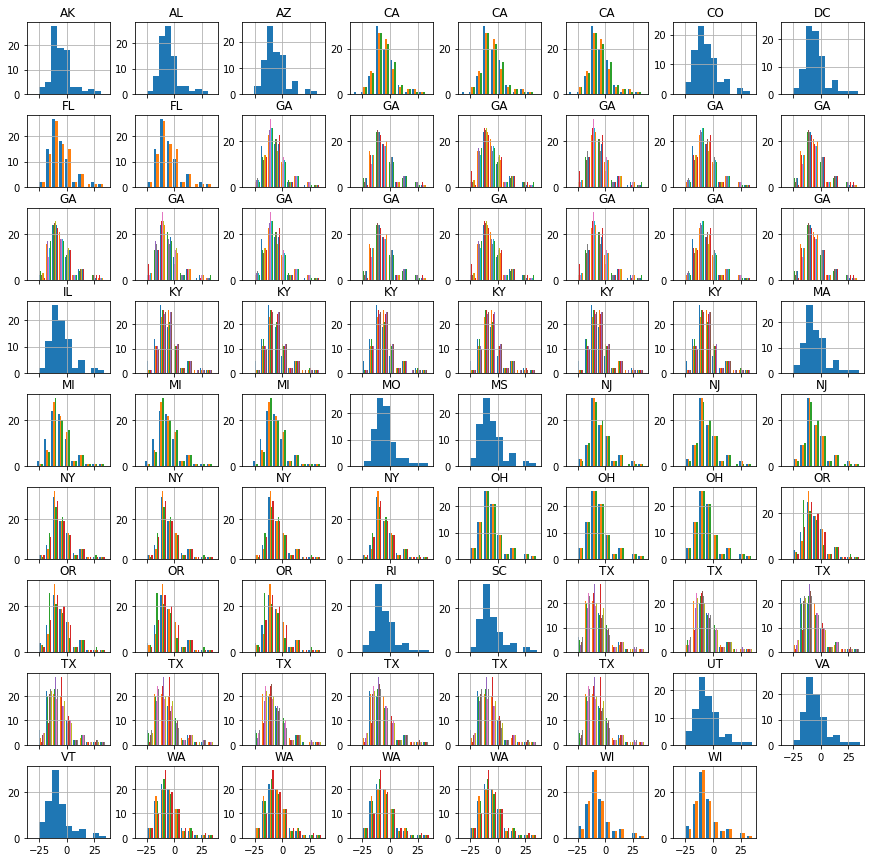

In [22]:
#View the distribution of each column
df_chill.hist(figsize=(15,15), sharex = True)

<AxesSubplot:xlabel='STATE', ylabel='STATE'>

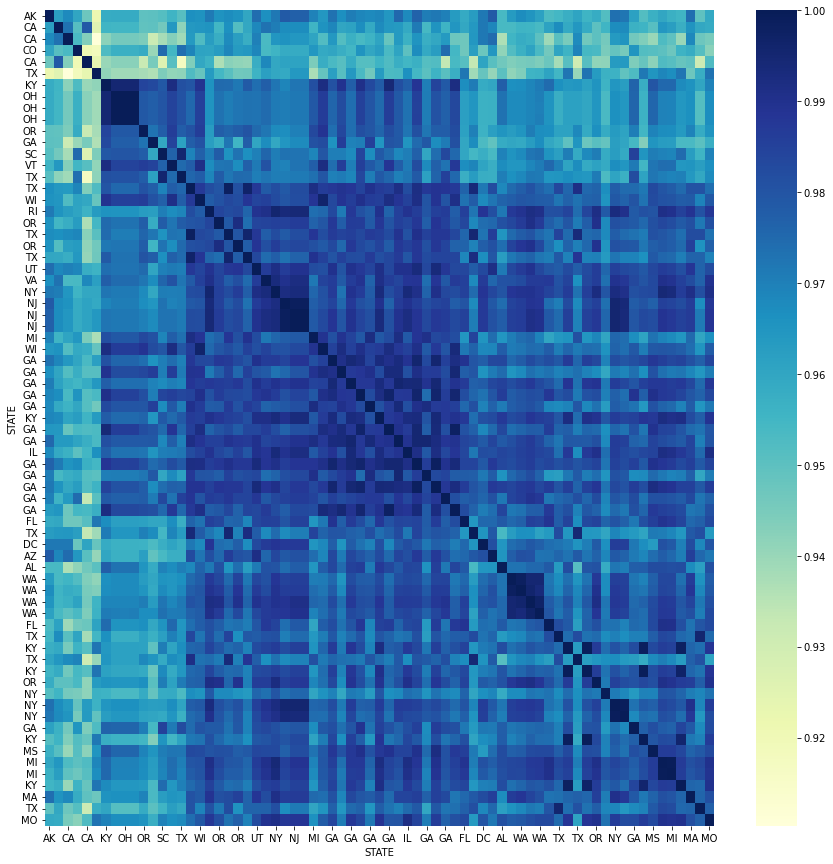

In [23]:
#view a correlation clusterplot of the data if you like that sort of thing

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(cluster_corr(df_chill.corr()), cmap='YlGnBu', ax=ax)

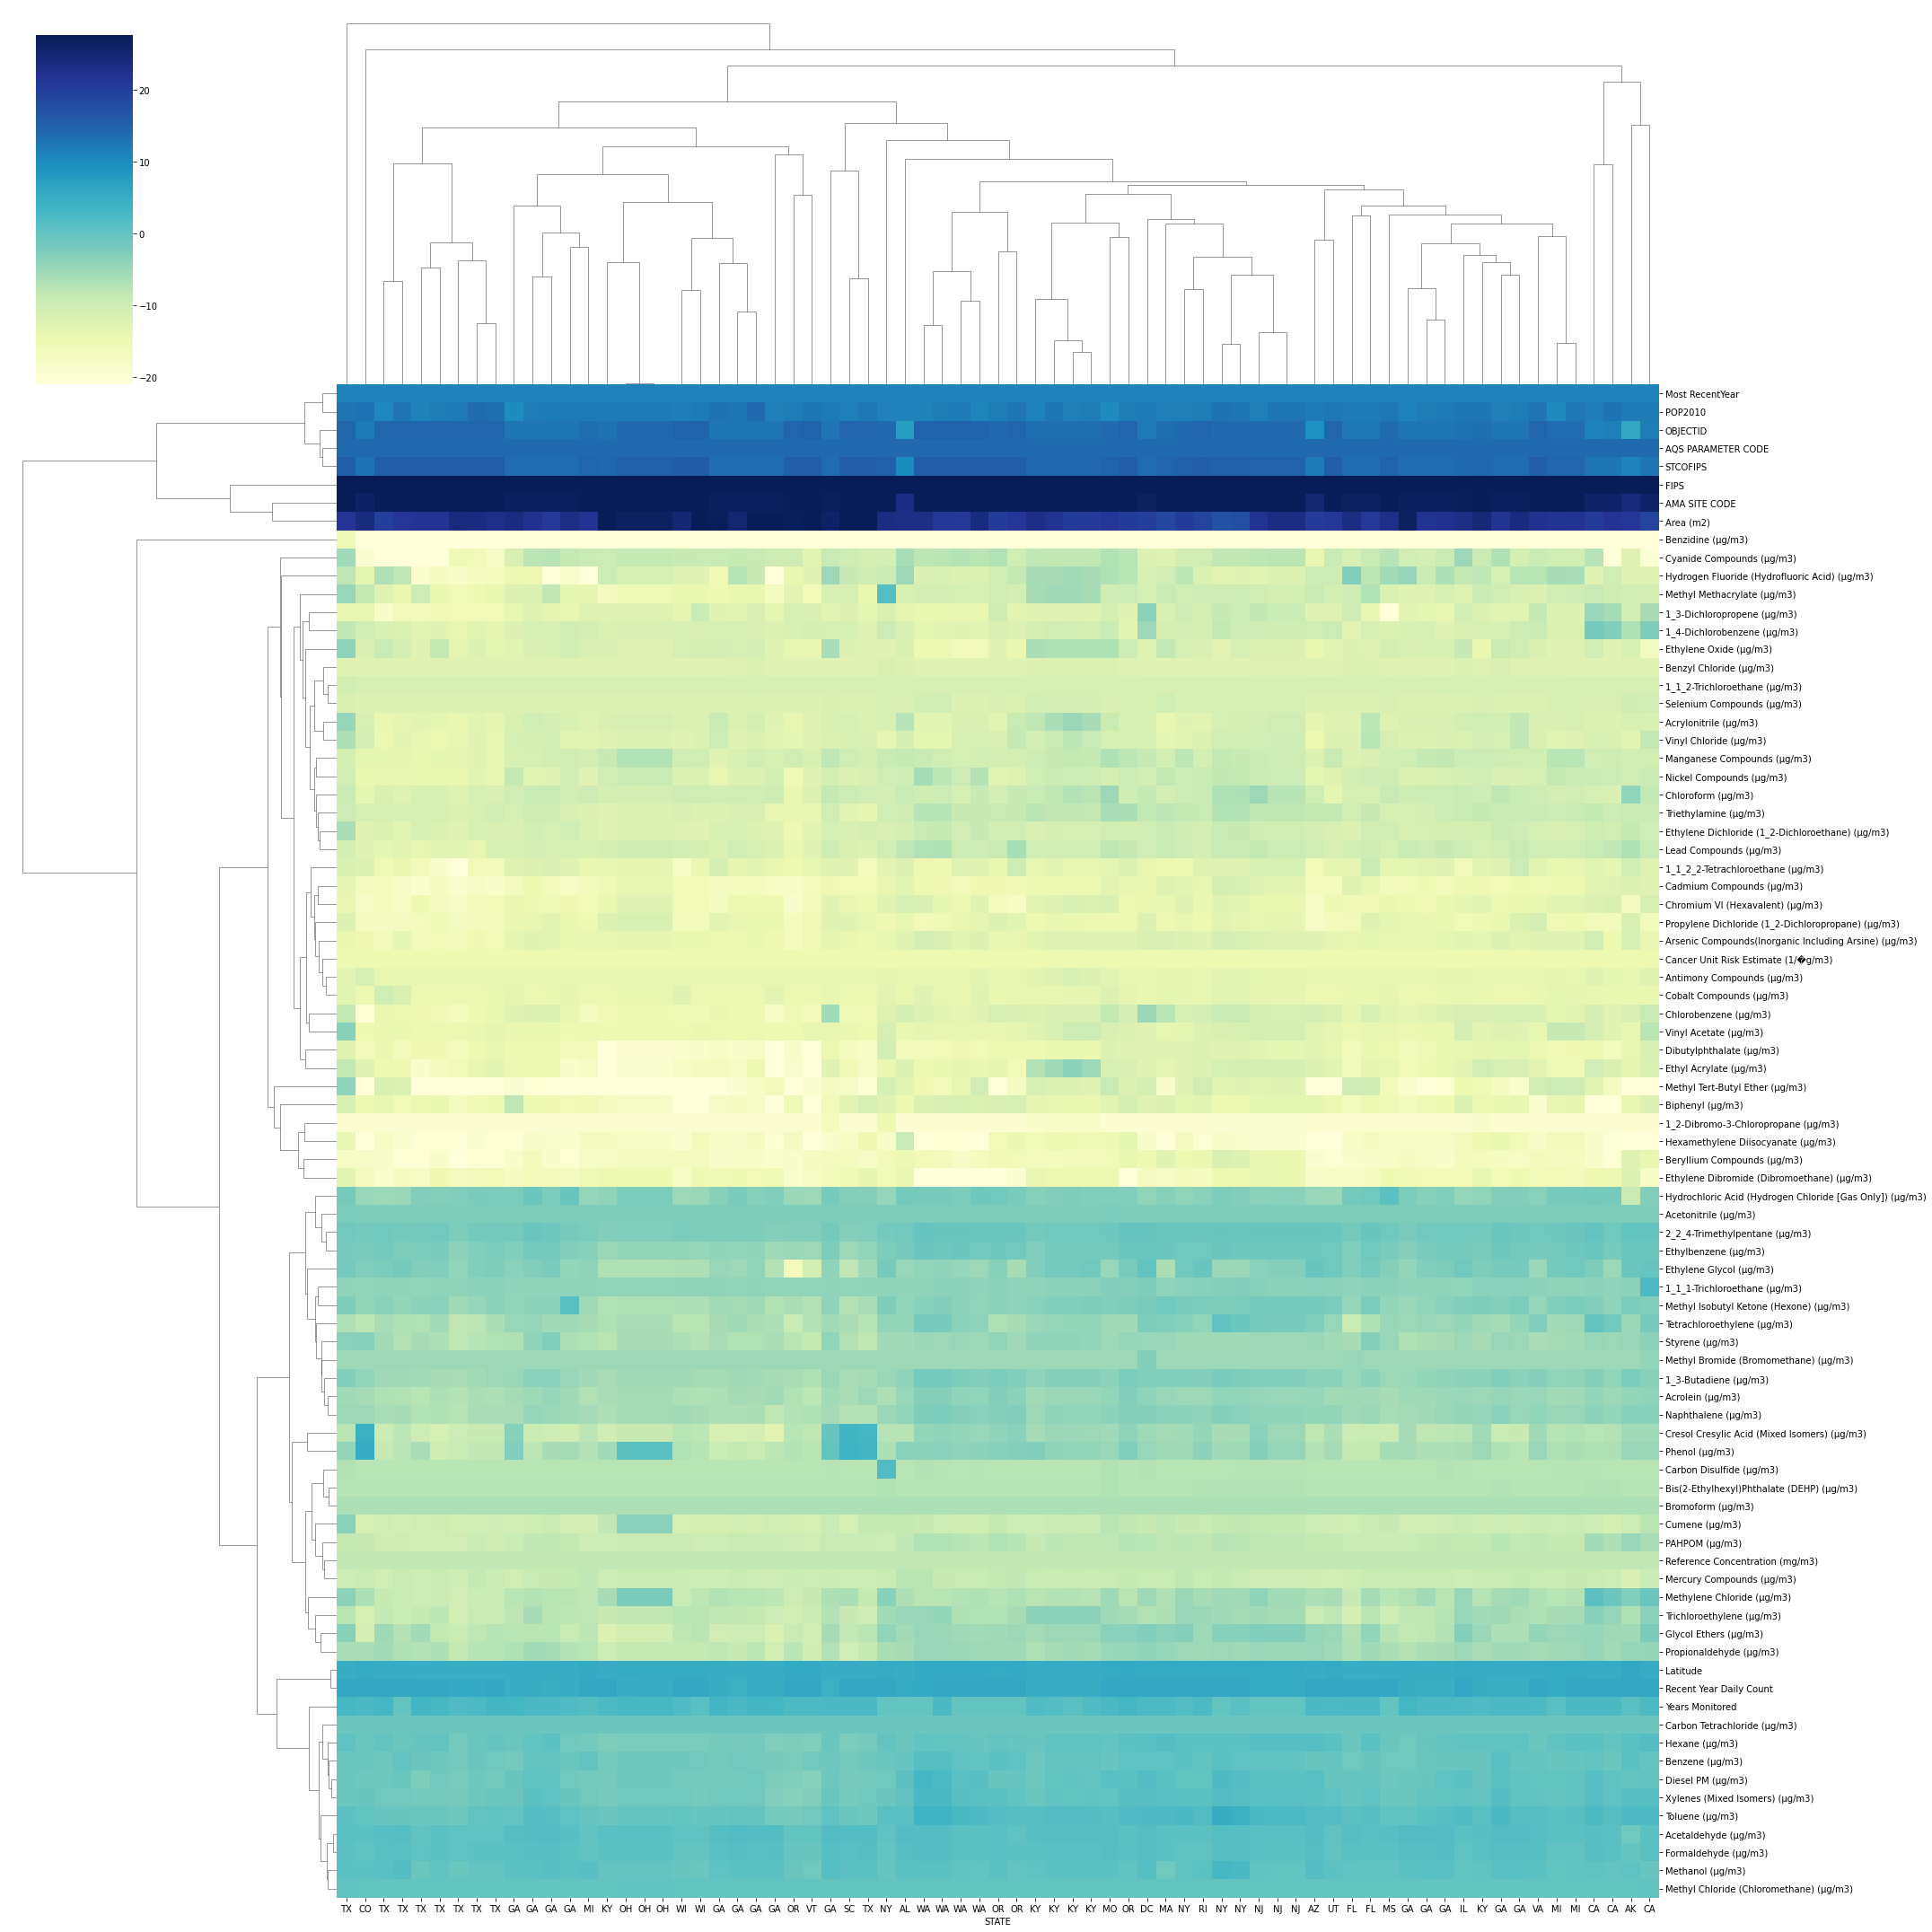

In [24]:
#heirarchical clustering of dataset
sns.clustermap(df_chill, robust = True, figsize=(30,30), cmap = "YlGnBu")